In [1]:
# import os
import sys
import gc

# прописываем нужный нам путь к проекту
from pathlib import Path
PATH = Path('../..') # proj_news_viz/nlp
sys.path.append(str(PATH))

import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

In [8]:
df = pd.read_csv(PATH / 'data/external/rt.csv', delimiter=',', quotechar='"', escapechar='\\')
print(df.shape)
df.sample(2)

(106644, 16)


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
2018-11-03 21:09:00,https://russian.rt.com/world/news/570300-miss-...,-,Мир,NaN,Обладательницей титула «Мисс Земля» стала пред...,Об этом сообщаетnRapplern.nТитул «Мисс Огонь» ...,-,-,-,-,-,-,-,-,-,NaN
2018-06-18 17:31:00,https://russian.rt.com/world/news/524918-lavro...,-,Мир,NaN,Лавров и Помпео обсудили урегулирование ситуац...,«В центре внимания была проблематика сирийског...,-,-,-,-,-,-,-,-,-,NaN


In [18]:
df = df[['edition','title']]
df = df.dropna()
print(df.shape)
df.isnull().sum()

(106632, 2)


edition    0
title      0
dtype: int64

In [24]:
df = df.rename({'edition':'topic','title':'text'},
               axis=1)
df = df.reset_index(drop=True)
df.sample(2)

,topic,text
73325,Спорт,«Отношение владельцев клубов к Олимпиаде такое...
106060,Спорт,"«Проект теннисного комплекса утверждён. Думаю,..."


In [25]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
df.topic.value_counts()

уникальное к-ство разделов: 10


Россия               32959
Спорт                26696
Мир                  26474
Бывший СССР          10078
Без политики          4489
Экономика             4321
Наука                 1496
Пресс-релизы            92
Новости партнёров       14
Мероприятия RT          13
Name: topic, dtype: int64

---
разделим данные для начала на train & test в соотношении 80/20 соответственно  со стратификацией по топиках

In [27]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.text,df.topic,
                                                    test_size=0.2,
                                                    stratify=df.topic,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85305,), (21327,), (85305,), (21327,))

In [30]:
# проверим на пустые значения
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
# добавим самописный файл, для отображения топ частотный слов
from news_viz.visualization.plot_frequency import plotFrequencyWords

* ### без препроцессинга

In [33]:
%%time

tfidf_vect = TfidfVectorizer()

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 11.7 s, sys: 2.46 s, total: 14.1 s
Wall time: 14.2 s


In [34]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 432423

пример [:5]: [('на', 3251.527395499927), ('что', 2855.6929891848145), ('не', 2116.4085550727564), ('по', 2001.0509803322166), ('россии', 1246.0749348562003)]


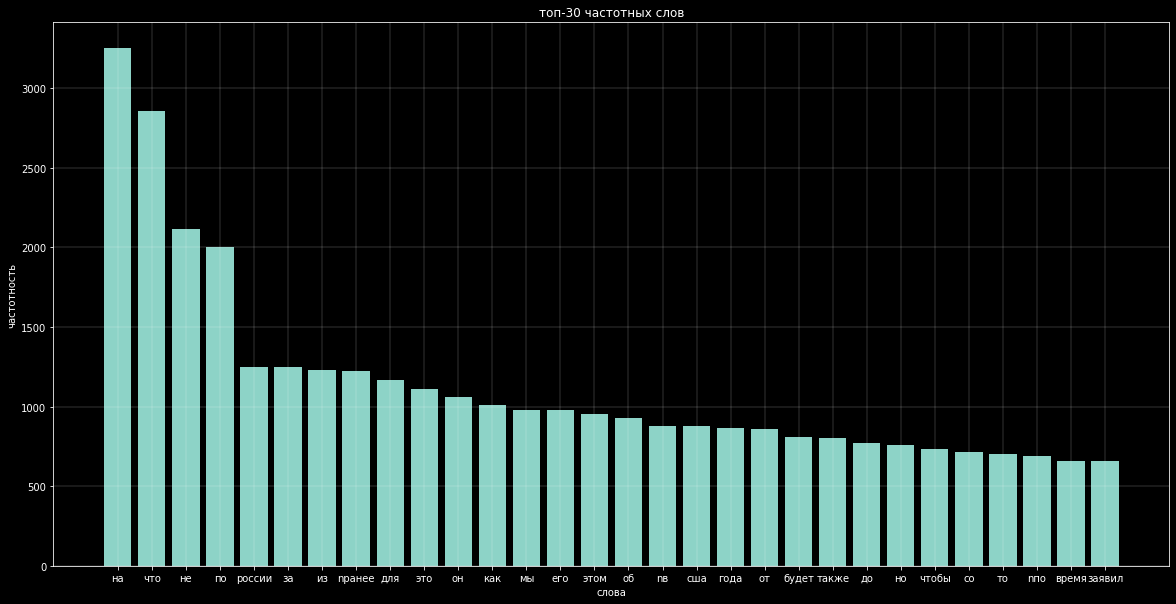

In [35]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [36]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
                   precision    recall  f1-score   support

     Без политики    0.60255   0.84076   0.70200       898
      Бывший СССР    0.78639   0.87103   0.82655      2016
   Мероприятия RT    0.00000   0.00000   0.00000         3
              Мир    0.85901   0.83078   0.84466      5295
            Наука    0.61965   0.82274   0.70690       299
Новости партнёров    0.00000   0.00000   0.00000         3
     Пресс-релизы    0.53846   0.77778   0.63636        18
           Россия    0.86740   0.76805   0.81471      6592
            Спорт    0.97793   0.96273   0.97027      5339
        Экономика    0.55976   0.76968   0.64815       864

         accuracy                        0.84578     21327
        macro avg    0.58112   0.66435   0.61496     21327
     weighted avg    0.85772   0.84578   0.84882     21327

confusion_matrix:
[[ 755   11    0   44   21    0    0   60    5    2]
 [  11 1756    0   82    3    1    0   98    2   63]
 [   0    0    0    1   

* ### c препроцессингом

In [37]:
# импортируем кастомный наш препроцессинг
from news_viz.data.preprocessing_tools import clean_text, lemmatize
# pip install pymorphy2

In [38]:
# импортируем нужные нам библиотеки для мультипроцессинга
# создаем соответствующую для этого функцию
import multiprocessing as mp
from multiprocessing import Pool

num_cores = mp.cpu_count() # number of cores on your machine; 20
num_partitions = num_cores * 2 # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [39]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* оставим только слова

In [40]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [41]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text != 'TOREMOVE']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text != 'TOREMOVE']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 1.86 s, sys: 1.45 s, total: 3.31 s
Wall time: 3.75 s


9461

* лемматизируем и удалим заодно стоп-слова

In [42]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatize)
    return data

In [43]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text != 'TOREMOVE']

gc.collect()

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text != 'TOREMOVE']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 3.24 s, sys: 2.13 s, total: 5.36 s
Wall time: 1min 27s


0

In [48]:
print(train.lemma_text.isnull().sum() , test.lemma_text.isnull().sum())

print(train.shape, test.shape)

train.sample(2)

0 0
(85214, 4) (21298, 4)


,text,target,clean_text,lemma_text
81924,Взрывное устройствоnсработалоnрядом с ресторан...,Мир,взрывное устройство сработало рядом рестораном...,взрывной устройство сработать ресторан район х...
55800,«На совещании у президента обсуждался вопрос и...,Россия,на совещании президента обсуждался вопрос инде...,совещание президент обсуждаться индексация пен...


---
* обучаем модель на очищенных данных

In [49]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [50]:
%%time

tfidf_vect_vect = TfidfVectorizer()

tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 6.44 s, sys: 1.01 s, total: 7.46 s
Wall time: 7.47 s


In [51]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 99941

пример [:5]: [('россия', 1780.5048788240413), ('новость', 1354.3709656551528), ('заявить', 1265.1016032457333), ('сообщаться', 1252.2374936989756), ('российский', 1249.950046751859)]


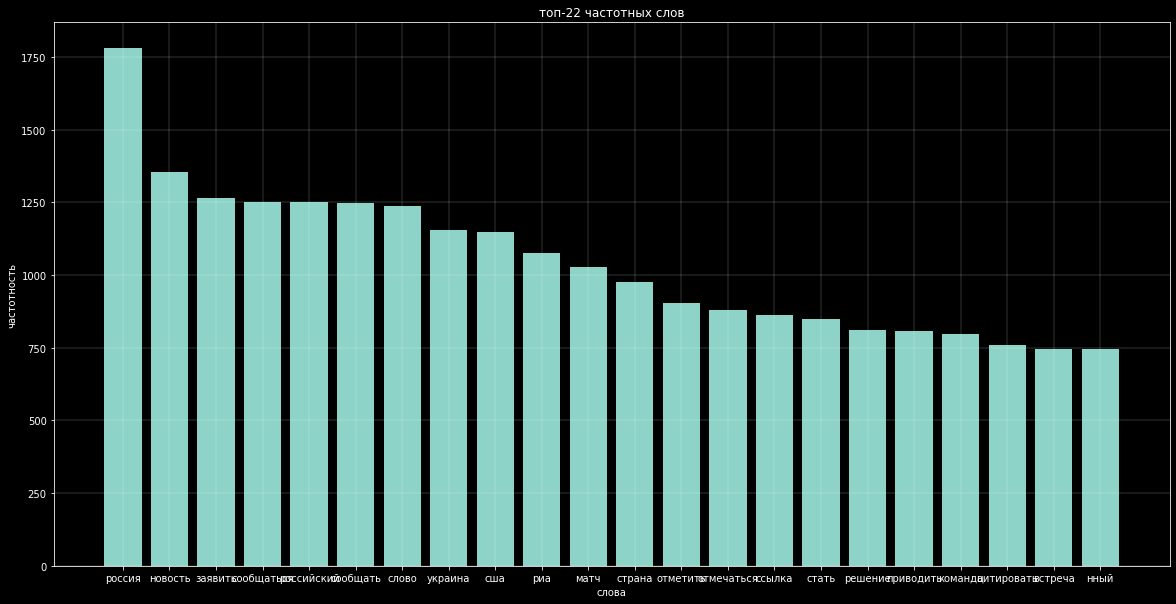

In [52]:
plotFrequencyWords(vocab = vocab,
                   top_words = 22,
                   plt_background = 'dark')

In [53]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
                   precision    recall  f1-score   support

     Без политики    0.60239   0.85231   0.70588       887
      Бывший СССР    0.78843   0.88542   0.83411      2016
   Мероприятия RT    0.00000   0.00000   0.00000         3
              Мир    0.86686   0.83097   0.84854      5289
            Наука    0.57016   0.85619   0.68449       299
Новости партнёров    0.00000   0.00000   0.00000         3
     Пресс-релизы    0.41935   0.72222   0.53061        18
           Россия    0.87959   0.75668   0.81352      6584
            Спорт    0.97806   0.96926   0.97364      5335
        Экономика    0.55364   0.81829   0.66044       864

         accuracy                        0.84820     21298
        macro avg    0.56585   0.66913   0.60512     21298
     weighted avg    0.86272   0.84820   0.85130     21298

confusion_matrix:
[[ 756   10    0   31   26    0    0   55    5    4]
 [  10 1785    0   61    3    0    0  100    1   56]
 [   0    0    0    1   